## A
Below is the code for part A. I used the function `euclidean_distance` both as a proximity measure and for calculating TSE, since they're the same apart from the summation. The stopping condition for this algorithm is

`if np.allclose(means,new_means) is True:
     break`
            
I tried to use the function `numpy.array_equal` but decided that was too precise for this algorithm. Specifically, the stopping condition was never met; but when I examined the dataframe the errors were the same out to the default printing length, 6 decimal places. Considering that these data points were randomly generated, I didn't see anything to be gained by comparing means at the $10^{-16}$ digit. `numpy.allclose` produced the same printed results with much fewer iterations.

Regardless of the number of clusters, I did not observe any run that took more than 10 iterations. For the seeds I selected to print/plot the data, it took 3 iterations for 2 clusters and 7 iterations for 4 clusters.

On seed  55  the algorithm converged after  3  iterations.



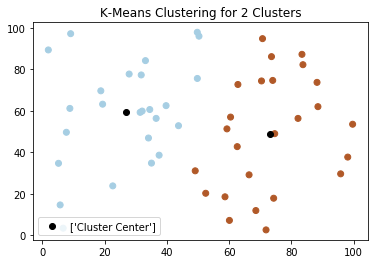

On seed  7  the algorithm converged after  6  iterations.

On seed  72  the algorithm converged after  10  iterations.

On seed  38  the algorithm converged after  7  iterations.

On seed  57  the algorithm converged after  3  iterations.

On seed  43  the algorithm converged after  5  iterations.

On seed  47  the algorithm converged after  7  iterations.

On seed  65  the algorithm converged after  4  iterations.

On seed  68  the algorithm converged after  10  iterations.

On seed  12  the algorithm converged after  3  iterations.

On seed  55  the algorithm converged after  7  iterations.



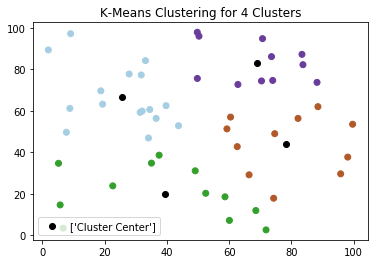

On seed  7  the algorithm converged after  6  iterations.

On seed  72  the algorithm converged after  7  iterations.

On seed  38  the algorithm converged after  6  iterations.

On seed  57  the algorithm converged after  7  iterations.

On seed  43  the algorithm converged after  10  iterations.

On seed  47  the algorithm converged after  5  iterations.

On seed  65  the algorithm converged after  7  iterations.

On seed  68  the algorithm converged after  3  iterations.

On seed  12  the algorithm converged after  8  iterations.



In [43]:
import pandas as pd
import numpy as np
import subprocess as sp
from numpy.random import default_rng
import matplotlib.pyplot as plt

sp.call('clear', shell = True)
#Functions for the proximity measurements
def square_error(x,mean):
    error = 0
    for dimension in range(len(x)):
        error += np.square(x[dimension] - mean[dimension])
    
    error = np.square(np.sqrt(error))
    return error
def euclidean_distance(x,mean):
    error = 0
    for dimension in range(len(x)):
        error += np.square(x[dimension] - mean[dimension])
        
    error = np.sqrt(error)
    return error

cluster = [2,4]

for k in cluster:
#I ran the line of code below once to generate my seeds. I then copied the
#results and commented it out. I left it here for you to see where the
##seeds came from.
    #seeds = rng.integers(low = 1, high = 100, size = 10)
    seeds = np.asarray([55,7,72,38,57,43,47,65,68,12])
    for seed in seeds:
        #Construct a random number generator for this seed and construct a
        #training set with it.
        rng = default_rng(seed)
    
        data_train = pd.DataFrame(
            np.zeros(shape = (50,3)), columns = ['x','y','Cluster'])
        for index in data_train.index:
            data_train.loc[index,'x'] = rng.uniform(low = 1,high = 100,size = 1)
            data_train.loc[index,'y'] = rng.uniform(low = 1,high = 100,size = 1)
    
        ##Create dataframe to contain errors##
        #Construct multi-level index
        index_array = [[None]*2*k for _ in range(2)]
        for i in range(1, k + 1):
            index_array[0][2 * i - 2] = 'Cluster '+str(i)
            index_array[0][2 * i - 1] = 'Cluster '+str(i)
            if i % 2 == 1:
                index_array[1][i - 1] = index_array[1][i + 1] = 'Intra-sq-dist'
            else:
                index_array[1][i - 1] = index_array[1][i + 1] = 'Intra-dist'
            if i % 4 == 0:
                index_array[1][6] = 'Intra-sq-dist'
                index_array[1][7] = 'Intra-dist'
        tuples = list(zip(*index_array))
        errors_index = pd.MultiIndex.from_tuples(tuples,names = ['first','second'])
        #Construct an empty dataframe with the index we created
        errors = pd.DataFrame(np.zeros(shape = (100,2*k)),
                              columns = errors_index)
        del(errors_index,tuples,index_array,i)
        errors['TSSE'] = errors['TSE'] = np.zeros(shape = len(errors))
        #General variables we'll need for the algorithm
        means = []
        iterations = 0
        
        #Initialize means 
        means = np.asarray(
            data_train[['x','y']].sample(
                n = k,replace = False,random_state = seed))
        
        #Main portion of the algorithm
        while iterations < 100:
            #Label each point to its correct cluster
            for index in data_train.index:
                minimal_distance = 200
                for mean in means:
                    distance = euclidean_distance(
                        x = np.asarray(data_train.iloc[index,0:2]),
                        mean = mean)
                    if distance < minimal_distance:
                        minimal_distance = distance
                        data_train.loc[index,'Cluster'] = mean[0]
            data_train = data_train.sort_values(by = 'Cluster').reset_index()
            del(distance, minimal_distance, data_train['index'])
            
            #Calculate the error for each cluster
            for mean in means:
                sum_square_error = 0
                sum_error = 0
                
                for index in data_train.index:
                    if data_train.loc[index,'Cluster'] == mean[0]:
                        sum_square_error += square_error(
                            x = np.asarray(data_train.iloc[index,0:2]),
                            mean = mean)
                        sum_error += euclidean_distance(
                            x = np.asarray(data_train.iloc[index,0:2]),
                            mean = mean)
                errors_index = np.argwhere(means[:,0] == mean[0])
                #Store errors for each cluster
                errors.loc[iterations,('Cluster '+str(errors_index[0,0] + 1),'Intra-sq-dist')] = sum_square_error
                errors.loc[iterations,('Cluster '+str(errors_index[0,0] + 1),'Intra-dist')] = sum_error
            #Calculate the total errors over this iteration
            errors.loc[iterations,'TSSE'] = errors.xs('Intra-sq-dist',axis = 1, level = 'second').loc[iterations,:].sum()
            errors.loc[iterations,'TSE'] = errors.xs('Intra-dist',axis = 1, level = 'second').loc[iterations,:].sum()
            del(errors_index)
            
            #Updata the mean for each cluster
            new_means = []
            for mean in means:
                individual_cluster = data_train[data_train['Cluster'] == mean[0]]
                new_means.append(np.asarray(individual_cluster.loc[:,['x','y']].mean()))
            
            new_means = np.asarray(new_means)
            #Stopping condition to check if the means have not changed over
            #this iteration
            if np.allclose(means,new_means) is True:
                break
            
            means = new_means
            iterations +=1

        #If the stopping condition was met, find the rows of our 'errors'
        #dataframe which were never used and remove them.
        errors = errors.where(errors > 0).dropna()
        
        #Print 1 sample dataframe of errors for each cluster    
        print("On seed ", seed, " the algorithm converged after ", len(errors), " iterations.\n")
        if seed == 55:
            display(errors.style.background_gradient(
                cmap = 'Blues').background_gradient(
                cmap = 'Greens',subset = ['TSSE','TSE']).set_caption('Error Reduction for '+str(k)+' Clusters').hide_index())
            color = data_train['Cluster']
            plt.scatter(data_train['x'],data_train['y'], c = color, cmap = 'Paired')
            plt.scatter(new_means[:,0],new_means[:,1],label = ['Cluster Center'], c = 'black')
            plt.legend(loc = 'lower left')
            plt.title('K-Means Clustering for '+str(k)+' Clusters')
            plt.show()
            

For 2 clusters, neither the individual cluster error or the total error increased on any iteration. That goes for both TSSE and TSE. That wasn't always the case. I did observe seeds where the individual cluster errors increased. However, there was no run of the algorithm where I observed an increase in TSSE or TSE.

For 4 clusters, you can see there were increases in the individual cluster errors. Predictably, the increase occured on the same iteration for each cluster for both error measures. Cluster 1 increased on the first three iteratoins, until it plateaued on the fourth.. Cluster 2 increased on the third, fifth, and sixth iterations. Cluster 3 increased on the fourth and fifth iterations, and and plateaued there until the algorithm stopped. Cluster 4 never saw in increase. These changes can be seen in the table at the points where the background color gets darker from the previous row. Again, there were no increases observed in the TSSE or TSE.

In general, for both 2 and 4 clusters, the individual clusters showed increases quite often, and I never observed a single increase for TSSE or TSE.

## B

The algorithm converged after  4  iterations.



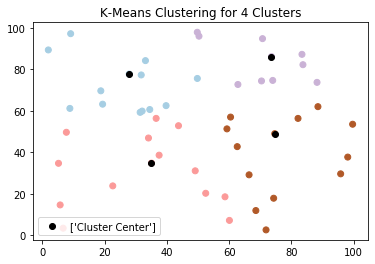

In [42]:
import pandas as pd
import numpy as np
import subprocess as sp
from numpy.random import default_rng
import matplotlib.pyplot as plt

sp.call('clear', shell = True)
#Functions for the proximity measurements
def square_error(x,mean):
    error = 0
    for dimension in range(len(x)):
        error += np.square(x[dimension] - mean[dimension])
    
    error = np.square(np.sqrt(error))
    return error
def euclidean_distance(x,mean):
    error = 0
    for dimension in range(len(x)):
        error += np.square(x[dimension] - mean[dimension])
        
    error = np.sqrt(error)
    return error

#############################################################################################################################################
#A new function for calculating the medoid of a cluster
def find_medoid(df):
    medoids = []
    #Re-index the dataframe so I can take cross-sections based on its cluster
    df = df.set_index(['index','Cluster'])
    
    for i in range(1, k + 1):
        #Select all rows where the points are labelled into cluster 'i', which is the sub-index of our dataframe, and reset the index to
        #begin at 0.
        df_cluster = df.xs(i, level = 1).reset_index()
        del(df_cluster['index'])
        #Empty matrix for storing the pairwise distances of each data point
        distance_matrix = np.zeros(shape = (len(df_cluster),len(df_cluster)))
        for index_row in df_cluster.index:
            for index_col in df_cluster.index:
                distance_matrix[index_row,index_col] = euclidean_distance(
                    df_cluster.iloc[index_row,0:2],
                    df_cluster.iloc[index_col,0:2])
        #Medoid is the row of the matrix with the lowest sum
        medoid = np.argmin(distance_matrix.sum(axis = 0))
        #The variable medoid was an index, so call the same index from our dataframe to be the new value.
        medoids.append(np.asarray(df_cluster.iloc[medoid,:]))
    medoids = np.asarray(medoids)
    return medoids
############################################################################################################################################

#Construct a random number generator for this seed and construct a
#training set with it.
k = 4
seed = 55
rng = default_rng(seed)

data_train = pd.DataFrame(
    np.zeros(shape = (50,3)), columns = ['x','y','Cluster'])
for index in data_train.index:
    data_train.loc[index,'x'] = rng.uniform(low = 1,high = 100,size = 1)
    data_train.loc[index,'y'] = rng.uniform(low = 1,high = 100,size = 1)

##Create dataframe to contain errors##

#Construct multi-level index
index_array = [[None]*2*k for _ in range(2)]
for i in range(1, k + 1):
    index_array[0][2 * i - 2] = 'Cluster '+str(i)
    index_array[0][2 * i - 1] = 'Cluster '+str(i)
    if i % 2 == 1:
        index_array[1][i - 1] = index_array[1][i + 1] = 'Intra-sq-dist'
    else:
        index_array[1][i - 1] = index_array[1][i + 1] = 'Intra-dist'
    if i % 4 == 0:
        index_array[1][6] = 'Intra-sq-dist'
        index_array[1][7] = 'Intra-dist'
tuples = list(zip(*index_array))
errors_index = pd.MultiIndex.from_tuples(tuples,names = ['first','second'])
#Construct an empty dataframe with the index we created
errors = pd.DataFrame(np.zeros(shape = (100,2*k)),
                      columns = errors_index)
del(errors_index,tuples,index_array,i)
errors['TSSE'] = errors['TSE'] = np.zeros(shape = len(errors))
#General variables we'll need for the algorithm
means = []
iterations = 0

#Initialize means 
means = np.asarray(
    data_train[['x','y']].sample(
        n = k,replace = False,random_state = seed))

while iterations < 100:
    #Label each point to its correct cluster
    for index in data_train.index:
        minimal_distance = 200
        for mean in means:
            distance = euclidean_distance(
                x = np.asarray(data_train.iloc[index,0:2]),
                mean = mean)
            if distance < minimal_distance:
                minimal_distance = distance
                data_train.loc[index,'Cluster'] = mean[0]
    data_train = data_train.sort_values(by = 'Cluster').reset_index()
    del(distance, minimal_distance, data_train['index'])

    #Calculate the error for a single cluster
    for mean in means:
        sum_square_error = 0
        sum_error = 0

        for index in data_train.index:
            if data_train.loc[index,'Cluster'] == mean[0]:
                sum_square_error += square_error(
                    x = np.asarray(data_train.iloc[index,0:2]),
                    mean = mean)
                sum_error += euclidean_distance(
                    x = np.asarray(data_train.iloc[index,0:2]),
                    mean = mean)
        errors_index = np.argwhere(means[:,0] == mean[0])
        #Store errors for each cluster
        errors.loc[iterations,('Cluster '+str(errors_index[0,0] + 1),'Intra-sq-dist')] = sum_square_error
        errors.loc[iterations,('Cluster '+str(errors_index[0,0] + 1),'Intra-dist')] = sum_error
    #Calculate the total errors over this iteration
    errors.loc[iterations,'TSSE'] = errors.xs('Intra-sq-dist',axis = 1, level = 'second').loc[iterations,:].sum()
    errors.loc[iterations,'TSE'] = errors.xs('Intra-dist',axis = 1, level = 'second').loc[iterations,:].sum()
    del(errors_index)
    
#############################################################################################################################################
    #Calculate the medoid and update the cluster means with them
    
    #I need to pass this column to `find_medoids` because the function re-indexes the dataframe and crashed without it.
    data_train['index'] = data_train.index
    #I want to take cross sections of the data based on each point's cluster. The next two commands were a way to make the cluster column
    #iterable.
    data_train['Cluster'] = data_train['Cluster'].replace(
        to_replace = data_train['Cluster'].unique(), value = [1,2,3,4])
    data_train['Cluster'] = data_train['Cluster'].astype('int64')
    
    medoids = find_medoid(data_train)
    del(data_train['index'])
#############################################################################################################################################
    
    #Same stopping condition as before
    if np.allclose(means,medoids) is True:
        break

    means = medoids
    iterations +=1
    
#If the stopping condition was met, find the rows of our 'errors'
#dataframe which were never used and remove them.
errors = errors.where(errors > 0).dropna()

print("The algorithm converged after ", len(errors), " iterations.\n")
errors_styled = errors.style.background_gradient(
    cmap = 'Blues').background_gradient(
    cmap = 'Greens',subset = ['TSSE','TSE']).set_caption('Error Reduction for '+str(k)+' Clusters').hide_index()
display(errors_styled)

color = data_train['Cluster']
plt.scatter(data_train['x'],data_train['y'], c = color, cmap = 'Paired')
plt.scatter(medoids[:,0],medoids[:,1],label = ['Cluster Center'], c = 'black')
plt.legend(loc = 'lower left')
plt.title('K-Means Clustering for '+str(k)+' Clusters')
plt.show()

As before, the individual clusters all show iterations where they increase, denoted by a cell being darker than the one aboove it. However, TSSE and TSE remained decreasing throughout the run. Since I used the same seed to print results as in part A, it's easy to see that the results are quite similar, but in fewer iterations.